<a href="https://colab.research.google.com/github/zhaozhiqiang1971/EGT214/blob/main/Practical5_RNN_Weather_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Practical 5 - Multiple features RNN for weather forecasting

In this practical, we practice to develop a complex RNN with multiple features for weather forecasting using jena_climate_2009_2016 dataset.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM

#Load and view data

In [ ]:
df = pd.read_csv("jena_climate_2009_2016.csv")
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


In [ ]:
#setting for easy read and plot
date_time_key = "Date Time"

titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

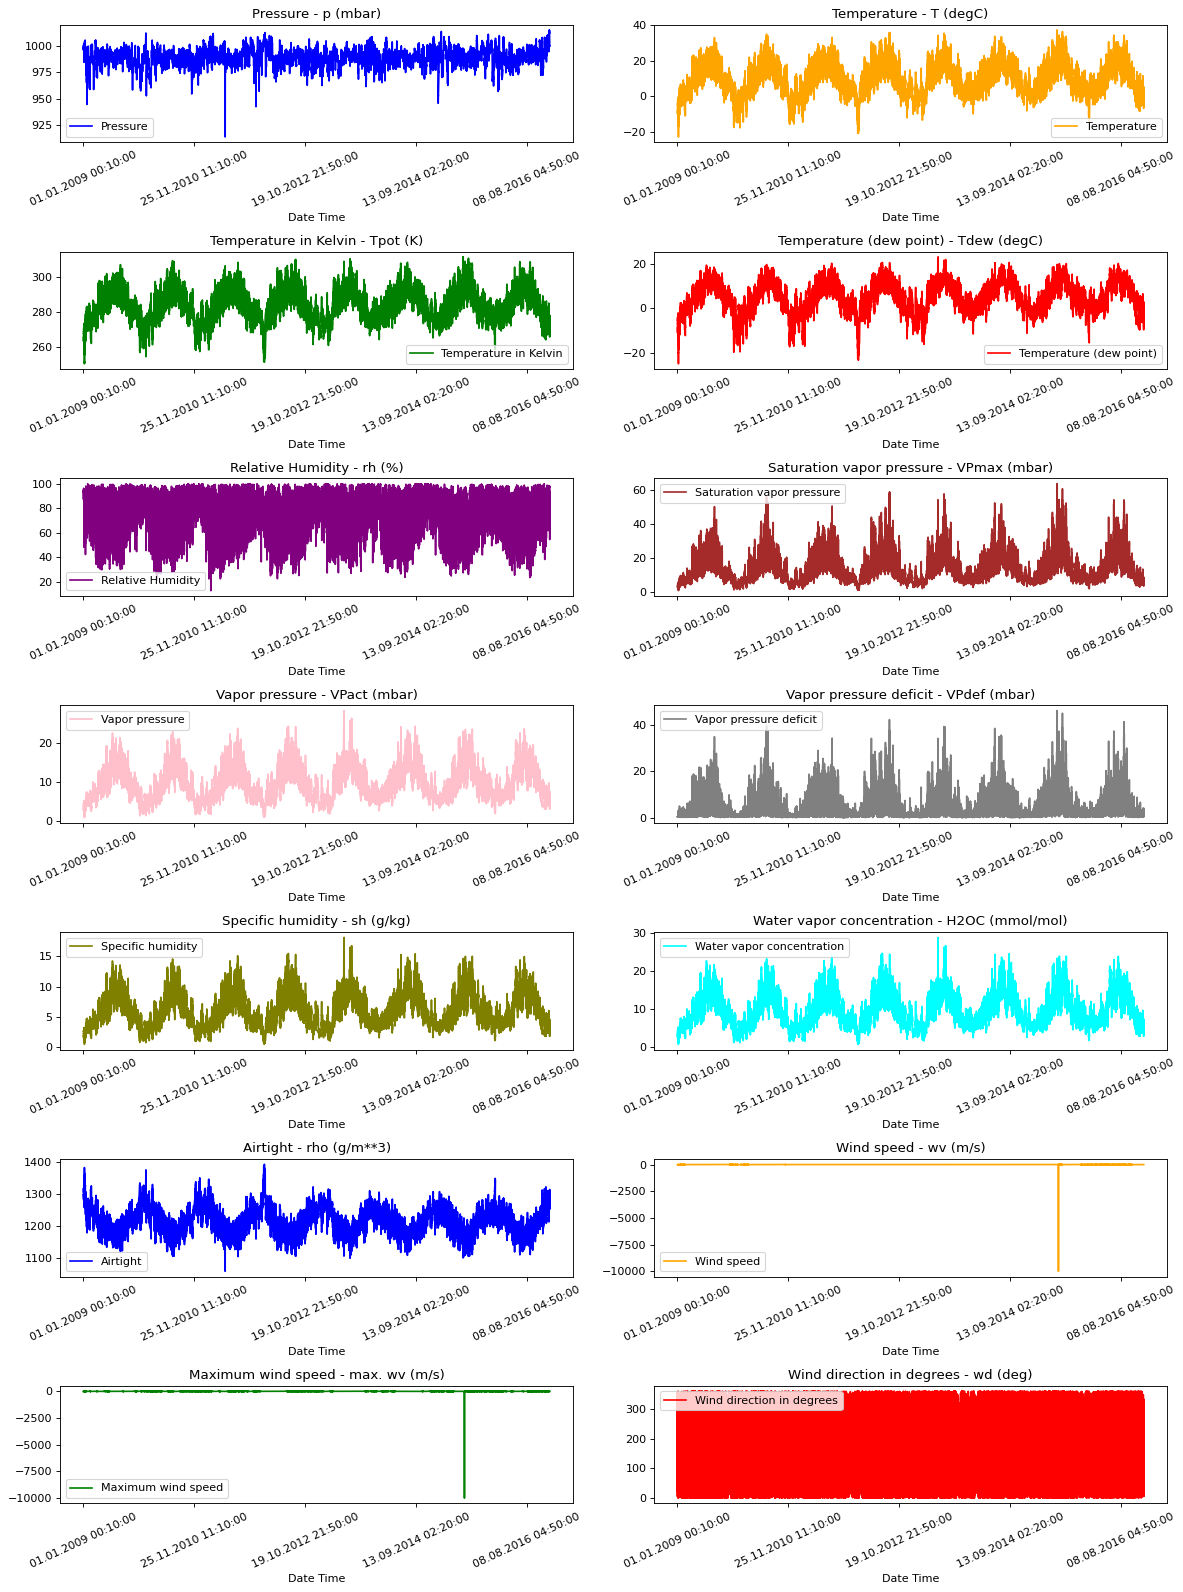

In [ ]:
#view different features/factors against weather conditions
def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k")
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()

show_raw_visualization(df)

#Prepare Sequence Data for RNN

In [ ]:
#RNN parameters
step = 6
past = 720
future = 72
learning_rate = 0.001
batch_size = 256
epochs = 5

In [ ]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))

def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

#select several features
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
print("The selected features:", ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]))
features = df[selected_features]
features.index = df[date_time_key]
features.head()

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

The selected features: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


,0,1,2,3,4,5,6
0,0.955451,-2.000020,-1.319782,-0.788479,-1.500927,2.237658,-0.732997
1,0.961528,-2.045185,-1.332806,-0.790561,-1.519521,2.287838,-0.936002
2,0.956666,-2.056766,-1.335410,-0.792642,-1.523239,2.298608,-1.283076
3,0.954236,-2.033604,-1.328898,-0.794724,-1.508364,2.272906,-1.184847
4,0.954236,-2.028972,-1.327596,-0.794724,-1.508364,2.268256,-1.197944


In [ ]:
#train & val datasets
train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

print(train_data.shape, val_data.shape)

(300693, 7) (119858, 7)


In [ ]:
#format data
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(7)]].values
y_train = features.iloc[start:end][[1]]

sequence_length = int(past / step)
x_train.shape, y_train.shape

((300693, 7), (300693, 1))

In [ ]:
#Here, we use keras.preprocessing.timeseries_dataset_from_array to generate sequence data for RNN
#In the previous practices, we define a fucntion slide_window
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

dataset_train

<_BatchDataset element_spec=(TensorSpec(shape=(None, None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

In [ ]:
#val data
x_end = len(val_data) - past - future
label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 120, 7)
Target shape: (256, 1)


#Define and Train RNN

In [ ]:
model = Sequential()
model.add(LSTM(units=32, input_shape=(inputs.shape[1], inputs.shape[2])))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="linear"))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 32)                  │           5,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,345 (36.50 KB)

 Trainable params: 9,345 (36.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
#we can adjust learning_rate of Adam optimizer to optimize the model
history = model.fit(dataset_train, epochs=5, validation_data=dataset_val)

Epoch 1/5
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 56s 46ms/step - loss: 0.3967 - val_loss: 0.1935
Epoch 2/5
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 51s 43ms/step - loss: 0.1556 - val_loss: 0.1617
Epoch 3/5
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 48s 41ms/step - loss: 0.1366 - val_loss: 0.1635
Epoch 4/5
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 51s 43ms/step - loss: 0.1325 - val_loss: 0.1641
Epoch 5/5
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 51s 43ms/step - loss: 0.1264 - val_loss: 0.1661


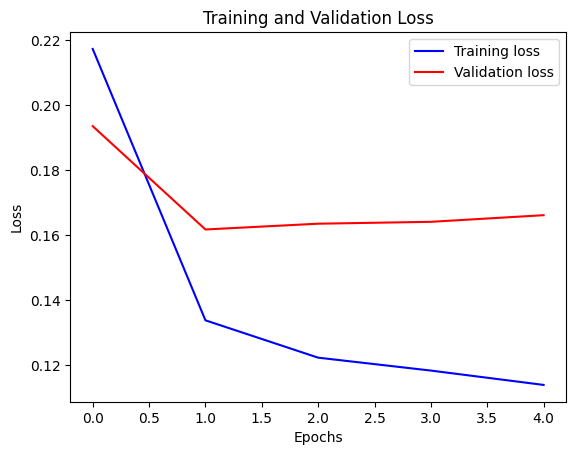

In [ ]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

visualize_loss(history, "Training and Validation Loss")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


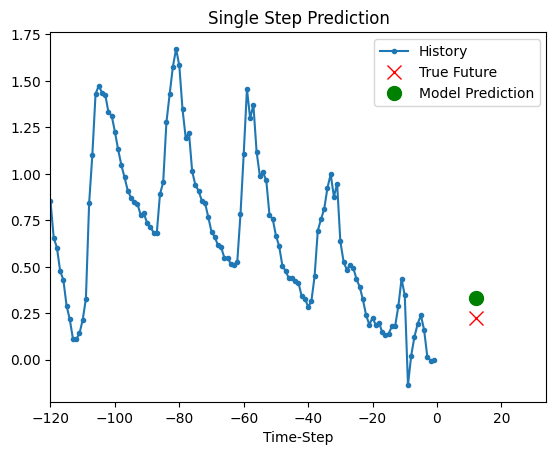

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


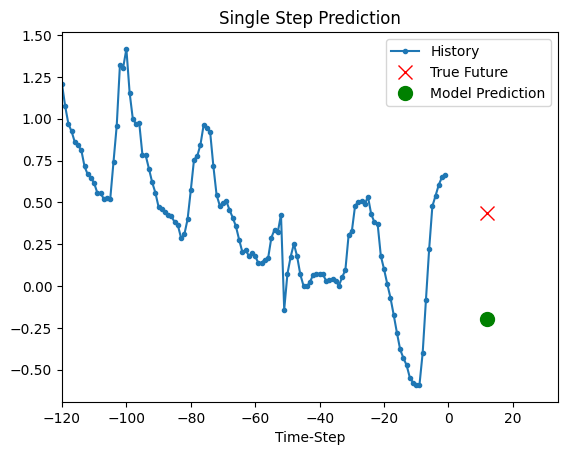

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


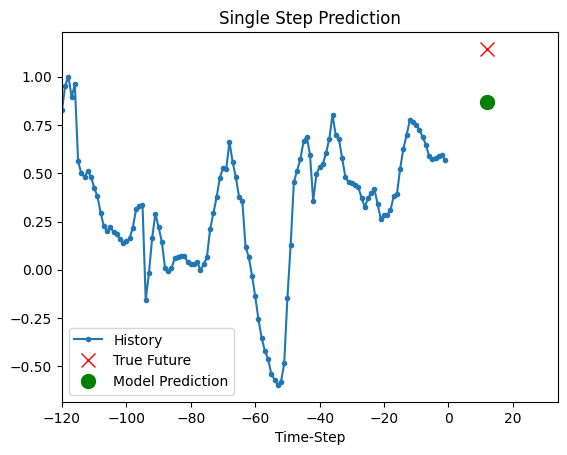

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


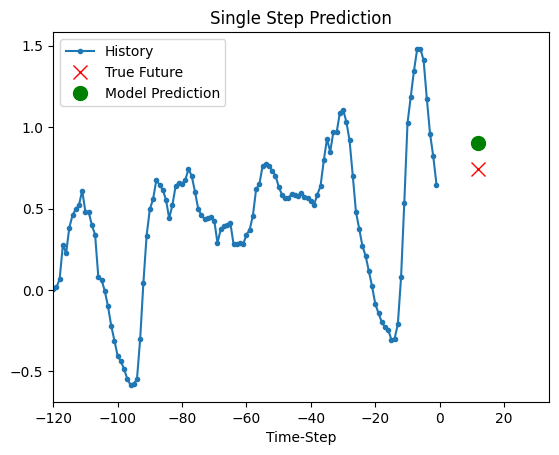

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


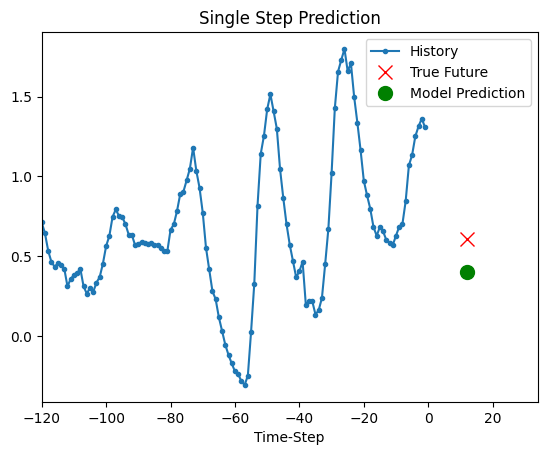

In [ ]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )

#Self Activity: Apply Early Stopping
- for big data tarining, Early Stopping technique helps to save training time.
- try 100 epoches

What is the epoches when the training  stops?

In [ ]:
path_checkpoint = "model_checkpoint.weights.h5"  #save the results
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
                  monitor="val_loss", filepath=path_checkpoint, verbose=1,
                  save_weights_only=True, save_best_only=True)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
history = model.fit(dataset_train, epochs=100, validation_data=dataset_val,
                    callbacks=[es_callback, modelckpt_callback])

Epoch 1/100
1171/1172 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1210
Epoch 1: val_loss improved from inf to 0.16702, saving model to model_checkpoint.weights.h5
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - loss: 0.1210 - val_loss: 0.1670
Epoch 2/100
1171/1172 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1217
Epoch 2: val_loss improved from 0.16702 to 0.16186, saving model to model_checkpoint.weights.h5
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 50s 43ms/step - loss: 0.1216 - val_loss: 0.1619
Epoch 3/100
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1185
Epoch 3: val_loss improved from 0.16186 to 0.15449, saving model to model_checkpoint.weights.h5
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 84s 44ms/step - loss: 0.1184 - val_loss: 0.1545
Epoch 4/100
1171/1172 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1149
Epoch 4: val_loss improved from 0.15449 to 0.15000, saving model to model_checkpoint.weights.h5
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 54s 46ms/step - loss: 0.1149 - val_loss: 0.1500
Epoch 5/100
1172/117

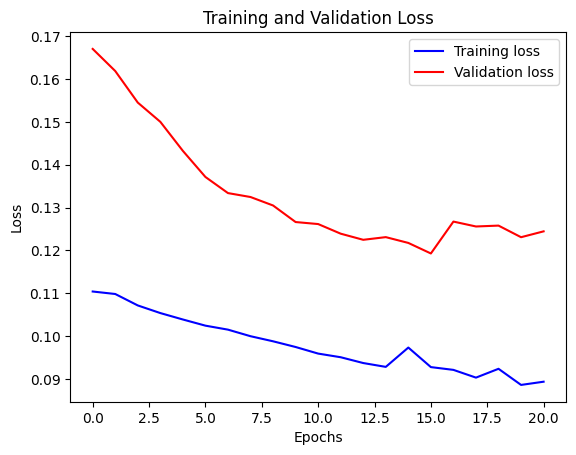

In [ ]:
visualize_loss(history, "Training and Validation Loss")